In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import statsmodels.stats.api as sms
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
sales = pd.read_csv('/content/train.csv', parse_dates=['Order Date'], dayfirst=True)


In [ ]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-11-08,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-06-12,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-10-11,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-10-11,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [ ]:
sales["Ship Date"] = pd.to_datetime(sales["Ship Date"], format="%d/%m/%Y")

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [ ]:
sales.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [ ]:
#MODE IMPUTATION FOR MISSING VALUES
mode_postal = sales["Postal Code"].mode()[0]
sales["Postal Code"] = sales["Postal Code"].fillna(mode_postal)
sales.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

In [ ]:
#CHECKING FOR DUPLICATES:
sales_dup = sales.duplicated().sum()
sales_dup

0

In [ ]:
sales[sales["Order Date"] > sales["Ship Date"]]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales


# Exploratory Data Analysis

In [ ]:
sales.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Row ID,9800.0,4900.5,1.0,2450.75,4900.5,7350.25,9800.0,2829.160653
Order Date,9800,2017-05-01 05:13:51.673469440,2015-01-03 00:00:00,2016-05-24 00:00:00,2017-06-26 00:00:00,2018-05-15 00:00:00,2018-12-30 00:00:00,NaN
Ship Date,9800,2017-05-05 04:17:52.653061120,2015-01-07 00:00:00,2016-05-27 18:00:00,2017-06-29 00:00:00,2018-05-19 00:00:00,2019-01-05 00:00:00,NaN
Postal Code,9800.0,55222.544694,1040.0,23223.0,57551.0,90008.0,99301.0,32059.043706
Sales,9800.0,230.769059,0.444,17.248,54.49,210.605,22638.48,626.651875


## Insights from the above desription
- We can see that the mean of sales (230.7690) is not affected by the extreme value (22638.48), since there are 9800 observations it has a smaller impact on the mean.
- Majority of the data points are clustered at the lower end. The median (54.49) is lower than the mean (230.7690) indicated that it is right skewed distribution. Most sales are low with a few high values pulling the mean up.
- Standard deviation (626.6518) is high implying that the data is wide spread, indicating that while most of the data are low there are significant deviations.

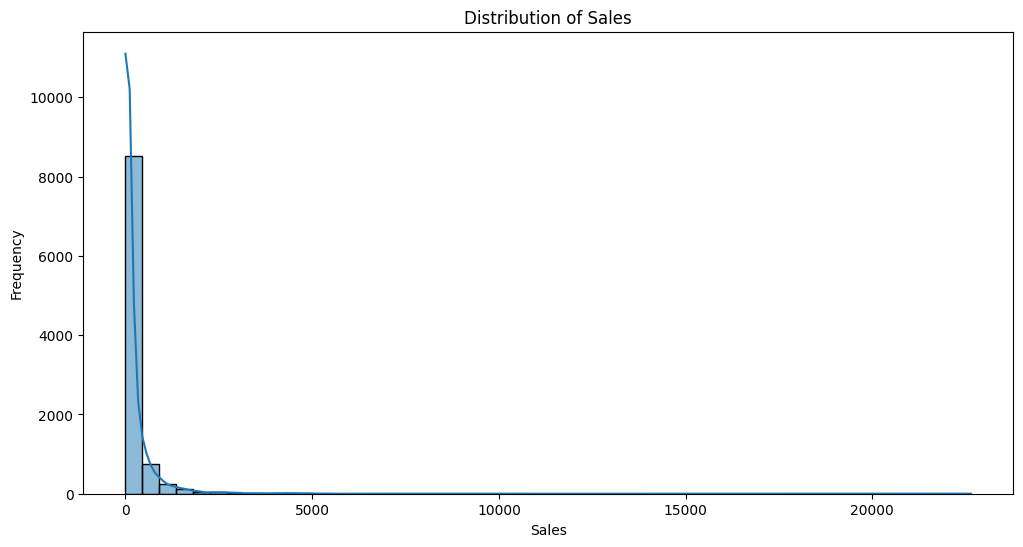

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(sales["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

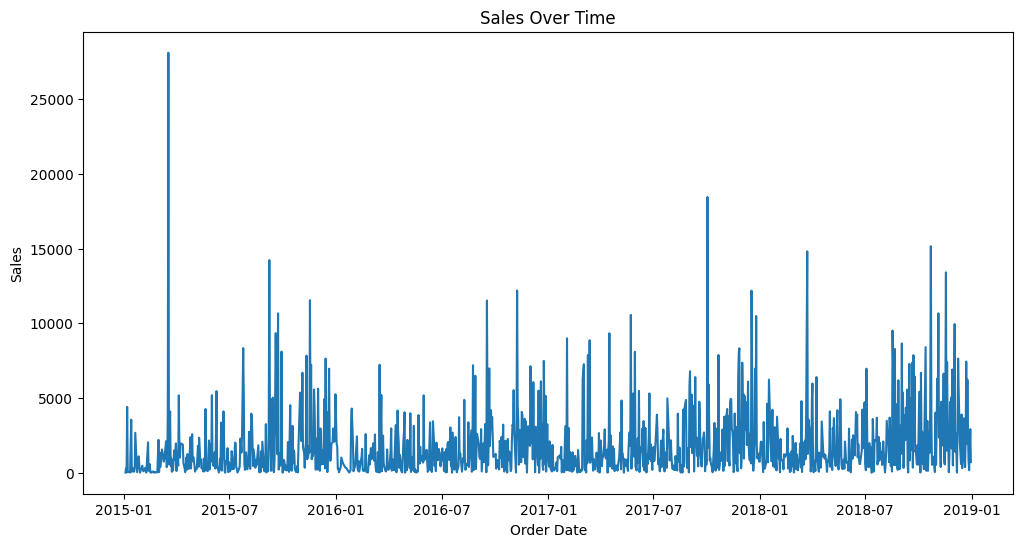

In [ ]:
sales_agg = sales.groupby("Order Date")["Sales"].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(sales_agg["Order Date"], sales_agg["Sales"])
plt.title("Sales Over Time")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.show()

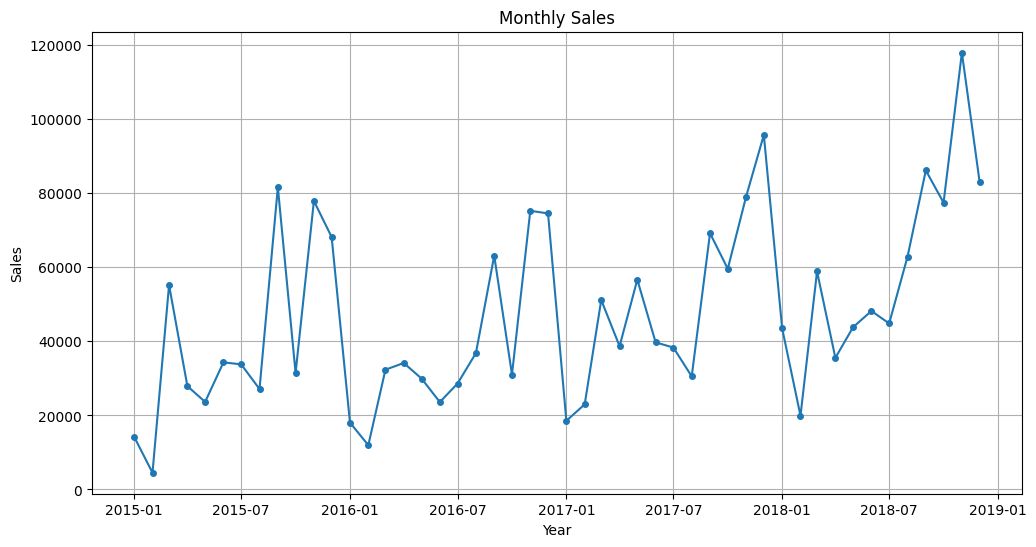

In [ ]:
sales["YearMonth"] = sales["Order Date"].dt.to_period("M")
Monthlysales = sales.groupby("YearMonth")["Sales"].sum().reset_index()
Monthlysales["YearMonth"] = Monthlysales["YearMonth"].dt.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(Monthlysales["YearMonth"], Monthlysales["Sales"], marker ="o", markersize=4)
plt.title("Monthly Sales")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

### Inferences from the plot:
- There are peaks indicating possible seasonal trends. There are higher sales during certain months indicating holiday seasons or cyclic events
- Upon comparing the data across months it is evident are there is growth year over year.
- The fluctuations during from one month to another indicates that the business is highly influenced by external factors like market demands, seasonal trends etc
- By pinpointing the months with lower sales, we can introduce various marketing strategies and campaigns to boost sales during these periods. Additionally, by analyzing sales during peak months, we can refine our strategies to further enhance sales performance.

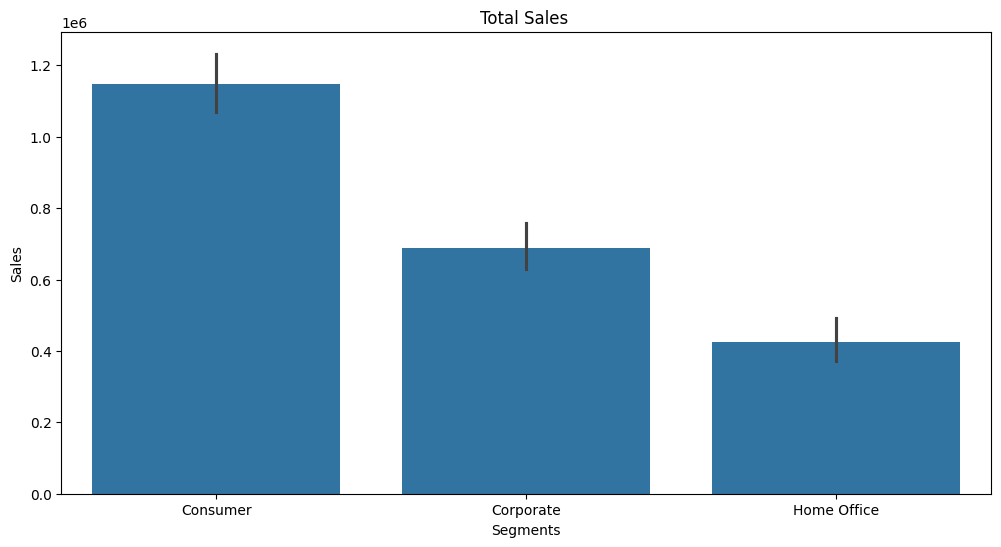

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x= "Segment", y="Sales", data = sales, estimator=sum)
plt.xlabel("Segments")
plt.ylabel("Sales")
plt.title("Total Sales ")
plt.show()

### Inferences from the barplot:

- The highest contributor on sales is the consumer segment, then comes corporate segments and lastly Home office.
- Improving marketing initiatives on Home office to boost the sales
- Analysing what makes the consumer segment sucessful and applying the similar strategies to corporate segments and home office
- Investigating the reason behind behind lower sales in corporate and home office segments to identify and resolve potential issues.

## Checking if the Time Series is Stationary


In [ ]:
value = adfuller(sales["Sales"])
stat = value[0]
critical_value = value[4]
print("ADF Statistics:", value[0])
print("p-values", value[1])

for key,value in value[4].items():
  print("Critical Values %a: %f,"  %(key,value))

if stat < critical_value['5%']:
  print("We reject the null Hypothesis: the time series is not stationary")
else:
  print("We reject the alternate hypothesis: The time series is stationary")

ADF Statistics: -98.33555319790369
p-values 0.0
Critical Values '1%': -3.431018,
Critical Values '5%': -2.861835,
Critical Values '10%': -2.566927,
We reject the null Hypothesis: the time series is not stationary


<Figure size 1400x1000 with 0 Axes>

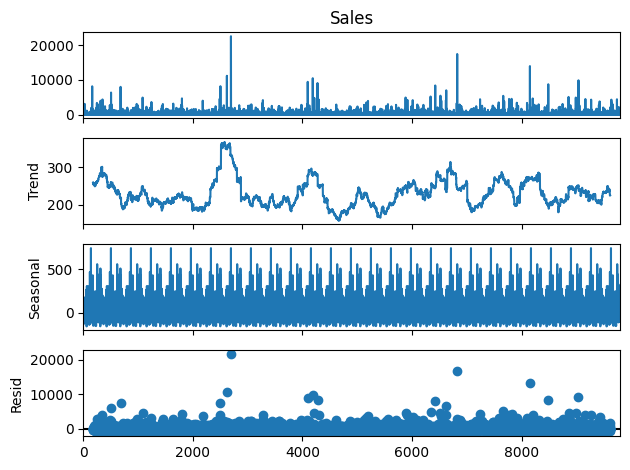

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(sales['Sales'], model='additive', period=365)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

- There is noticible fluctuations in the trend, but not clear if its an overall increasing or decreasing pattern.
- There is strong and consistent seasonal pattern.
-There are significant variations, with large residuals indicating outliers


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1079.923, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.37 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.20 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.25 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.15 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.72 sec
 ARIMA(2,1,0)(1,0,1

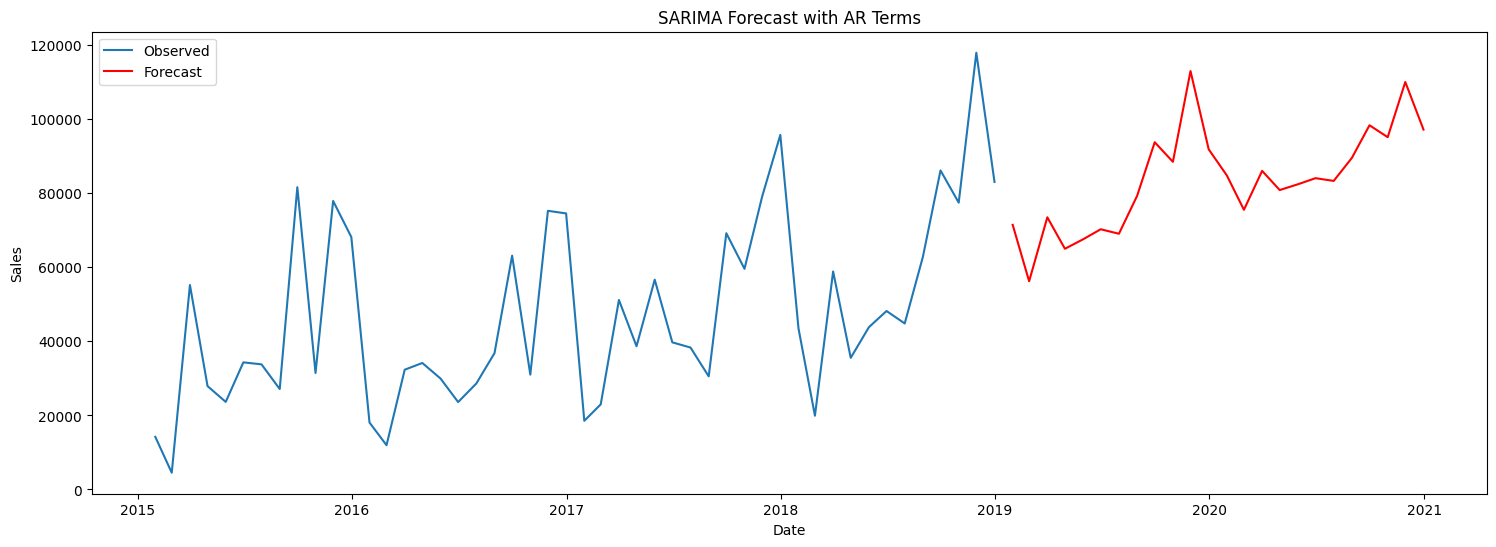

In [ ]:
sales.set_index("Order Date", inplace=True)
monthly_sales = sales['Sales'].resample('M').sum()
auto_model = pm.auto_arima(monthly_sales, seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = (2, auto_model.order[1], 1)  # p=2, d=auto_model.order[1], q=1
seasonal_order = auto_model.seasonal_order
sarima_model = SARIMAX(monthly_sales,
                       order=order,
                       seasonal_order=seasonal_order).fit(disp=False)
print(sarima_model.summary())
forecast = sarima_model.forecast(steps=24)

plt.figure(figsize=(18, 6))
plt.plot(monthly_sales, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA Forecast with AR Terms')
plt.legend()
plt.show()

#### Here we performed Seasonal AutoRegressive Integrated Moving average model to forecast the monthly sales data. We used the auto-arima function from pmdarima library which finds the best model parameters. The model forecasts sales for next 24 months. With the help of forecasted sales we can set realistic targets. Also the predicted decline in the sales would help us review the current strategies to identify areas of improvement.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1079.923, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=1.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.19 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.17 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.51 sec
 ARIMA(2,1,0)(1,0,1

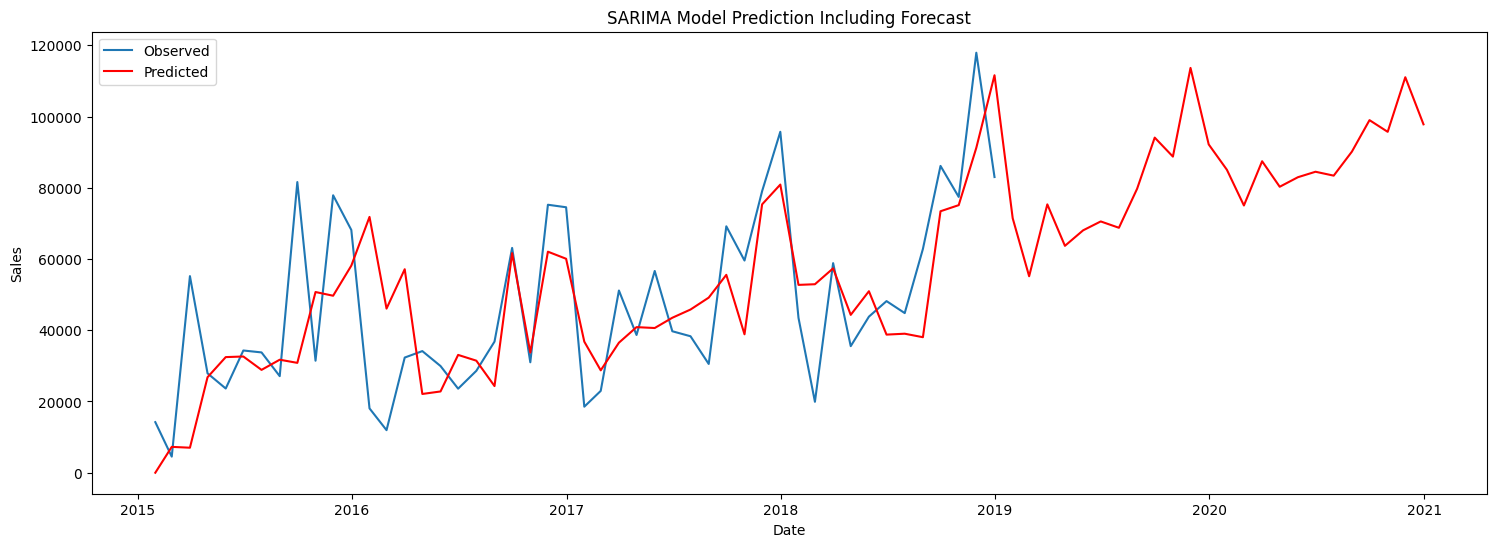

In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(monthly_sales, seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_model.order
seasonal_order = auto_model.seasonal_order
sarima_model = SARIMAX(monthly_sales, order=order, seasonal_order=seasonal_order).fit(disp=False)
in_sample_preds = sarima_model.predict(start=monthly_sales.index[0], end=monthly_sales.index[-1])
forecast_steps = 24
out_sample_preds = sarima_model.forecast(steps=forecast_steps)
all_preds = pd.concat([in_sample_preds, out_sample_preds])

plt.figure(figsize=(18, 6))
plt.plot(monthly_sales, label='Observed')
plt.plot(all_preds, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA Model Prediction Including Forecast')
plt.legend()
plt.show()


#### The red line denotes the model predictions including the in-sample-fit and forecast(out-sample) for 24 months. The model has captured the trend and seasonal fluctuations though some deviations highlight some potential refinement. The predictions are important to us to optimize business operations, anticipate market demands and make data-driven decisions

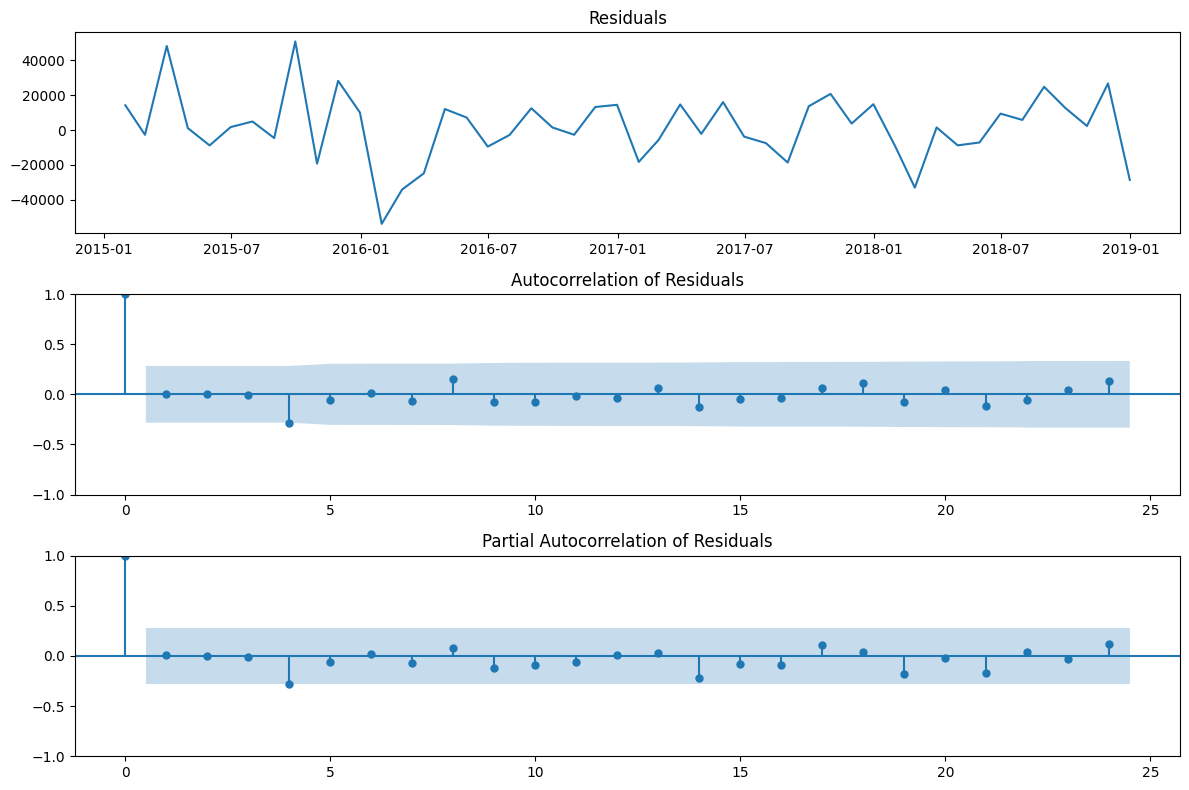

In [ ]:
# Plot the residuals
residuals = sarima_model.resid

plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(312)
sm.graphics.tsa.plot_acf(residuals, lags=24, ax=plt.gca())
plt.title('Autocorrelation of Residuals')

plt.subplot(313)
sm.graphics.tsa.plot_pacf(residuals, lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

#### Insights from the residue, ACF and PACF plots:
####* The residuals appear to be randomly scattered around 0, which suggest that the model has captured the underlying patterns in the data
####* Autocorrelation and partial auto correlation indicates that the residue does not show significant autocorrelation and partial autocorrelation, which apparently indicates that the model has accounted for time-dependency structures in the data.

#Ljung-Box Test Results

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10   7.013698   0.724151
20  10.636209   0.955117


#### We observe that for the lag 10 as well as for lag 20 the p-value is 0.81 and 0.97 which is greater than 0.05, indicating there is no significant autocorrelation in the residuals. This suggests that the SARIMA has captured the structures in the data leaving the residual closer to white noise.

In [ ]:
#Heteroscedasticity Test:
constant = np.ones(len(residuals))
dummy_variable = np.arange(len(residuals))
exog = np.column_stack((constant, dummy_variable))
# Breusch-Pagan test for heteroscedasticity
bp_test = sms.het_breuschpagan(residuals, exog)
print(f'Breusch-Pagan Test: LM Statistic={bp_test[0]}, p-value={bp_test[1]}, F-Statistic={bp_test[2]}, F p-value={bp_test[3]}')

Breusch-Pagan Test: LM Statistic=1.9072850138877726, p-value=0.16726515581683543, F-Statistic=1.903448531189196, F p-value=0.1743628490792533


In [ ]:
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

Shapiro-Wilk Test: Statistic=0.9698629379272461, p-value=0.2502320408821106


#### We perform the Breusch-Pagan and shapiro-Wilk test to check if the residuals have constant variance over time and to ensure the residuals are normally distributed

* Breusch-Pagan Test: p-value=0.1421 indicates no significant heteroscedasticity.
* Shapiro-Wilk Test: p-value=0.2826 indicates that the residuals are normally distributed.